# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [194]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# importing Cross validation libs
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
# ROC , AUC curve
# roc curve and auc
from sklearn.datasets import make_classification
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve, auc
# kFold
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV

import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
from sklearn.metrics import f1_score,recall_score,precision_score

import os
from joblib import dump, load

In [195]:
# using SQLite Table to read data.
con = sqlite3.connect(r'/home/pranay/ML datasource/amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [196]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [197]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [198]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [199]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [200]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [201]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [202]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [203]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [204]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [205]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [206]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [207]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [208]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [209]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [210]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [211]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [212]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [213]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [214]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [215]:
#filtered out whole reviews

from bs4 import BeautifulSoup
# Combining all the above stundents 
from tqdm import tqdm
# tqdm is for printing the status bar

word_counter = []
def filterised_text(text):
    preprocessed_text = []
    loop_size = 1
    for sentance in tqdm(text):
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
        preprocessed_text.append(sentance.strip())
        count = len(sentance.strip().split()) 
        word_counter.append(count)
    return preprocessed_text

In [216]:
preprocessed_reviews = filterised_text(final['Text'].values)
final['preprocessed_reviews']  = preprocessed_reviews
preprocessed_reviews[1]

100%|██████████| 87773/87773 [00:27<00:00, 3175.59it/s]


'dogs love saw pet store tag attached regarding made china satisfied safe'

In [217]:
final['numbers_of_words']  = word_counter
len(word_counter)

87773

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [218]:
preprocessed_summary = filterised_text(final['Summary'].values)
final['preprocessed_summary']  = preprocessed_summary
preprocessed_summary[1822]

100%|██████████| 87773/87773 [00:16<00:00, 5196.53it/s]


'pop corn'

In [219]:
bow_trained_model_25000 ='/home/pranay/ML trained models/BoW/bow_trained_model_25000'
bow_test_model_25000 ='/home/pranay/ML trained models/BoW/bow_test_model_25000'
bow_trained_model_20000 ='/home/pranay/ML trained models/BoW/bow_trained_model_20000'
bow_trained_model_100000 ='/home/pranay/ML trained models/BoW/bow_trained_model_100000'
bow_test_model_100000 ='/home/pranay/ML trained models/BoW/bow_test_model_100000'
bow_trained_count_vect ='/home/pranay/ML trained models/BoW/bow_trained_count_vect'

tf_idf_trained_model_25000 = '/home/pranay/ML trained models/TFIDF/tf_idf_trained_model_25000'
tf_idf_test_model_25000 = '/home/pranay/ML trained models/TFIDF/tf_idf_test_model_25000'
tf_idf_trained_model_20000 = '/home/pranay/ML trained models/TFIDF/tf_idf_trained_model_20000'
tf_idf_trained_model_100000 = '/home/pranay/ML trained models/TFIDF/tf_idf_trained_model_100000'
tf_idf_test_model_100000 = '/home/pranay/ML trained models/TFIDF/tf_idf_test_model_100000'
trained_tf_idf_vect_20000 = '/home/pranay/ML trained models/TFIDF/tf_idf_vect_20000'
tfidf_vectorizer ='/home/pranay/ML trained models/BoW/tfidf_vectorizer'

w2v_trained_model_20000 = '/home/pranay/ML trained models/W2V/w2v_trained_model_20000'
avg_w2v_trained_model_25000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_25000'
avg_w2v_test_model_25000 = '/home/pranay/ML trained models/W2V/avg_w2v_test_model_25000'
avg_w2v_trained_model_20000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_20000'
avg_w2v_trained_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_trained_model_100000'
avg_w2v_test_model_100000 = '/home/pranay/ML trained models/W2V/avg_w2v_test_model_100000'


w2v_tf_idf_trained_model_25000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_25000'
w2v_tf_idf_test_model_25000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_test_model_25000'
w2v_tf_idf_trained_model_20000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_20000'
w2v_tf_idf_trained_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_trained_model_100000'
w2v_tf_idf_test_model_100000 = '/home/pranay/ML trained models/W2V_TFIDF/w2v_tf_idf_test_model_100000'
w2v_tf_idf_model_20000 = '/home/pranay/ML trained modelsW2V_TFIDF/w2v_tf_idf_model_20000'

knn_trained_bow = '/home/pranay/Amazon Assignments/KNN/BOW/bow_optimal'
knn_trained_tfidf = '/home/pranay/Amazon Assignments/KNN/TFIDF/tfidf_optimal'
knn_trained_w2v = '/home/pranay/Amazon Assignments/KNN/W2V/w2v_optimal'
knn_trained_w2v_tfidf = '/home/pranay/Amazon Assignments/KNN/W2V TFIDF/w2v_tfidf_optimal'


### Splitting data

In [220]:

X = final['preprocessed_reviews']
y = final['Score']

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(61441,) (26332,) (61441,) (26332,)


# [4] Featurization

## [4.1] BAG OF WORDS

In [221]:
#BoW

# Train Vectorizor
# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(bow_trained_model_100000)

if exists:
    print("yes exist")
    final_bow_count_vect = load(bow_trained_model_100000) 
    bow_count_vect = load(bow_trained_count_vect)
    print("the type of count vectorizer ",type(final_bow_count_vect))
    print("the shape of out text BOW vectorizer ",final_bow_count_vect.get_shape())
    print("the number of unique words ", final_bow_count_vect.get_shape()[1])
else:
    print("not exist")
    bow_count_vect = CountVectorizer() #in scikit-learn
    bow_count_vect.fit(X_train)
    print("some feature names ", bow_count_vect.get_feature_names()[:10])
    print('='*50)
    final_bow_count_vect = bow_count_vect.fit_transform(X_train)
    print("the type of count vectorizer ",type(final_bow_count_vect))
    print("the shape of out text BOW vectorizer ",final_bow_count_vect.get_shape())
    print("the number of unique words ", final_bow_count_vect.get_shape()[1])
    dump(final_bow_count_vect, bow_trained_model_100000) 
    dump(bow_count_vect, bow_trained_count_vect) 

    
# Test Vectorizor
exists = os.path.isfile(bow_test_model_100000)

if exists:
    final_bow_test = load(bow_test_model_100000)
else:
    final_bow_test = bow_count_vect.transform(x_test)
    dump(final_bow_test,bow_test_model_100000 )
    final_bow_test.shape

yes exist
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (61441, 46446)
the number of unique words  46446


## [4.2] TF-IDF

In [222]:
# Train Vectorizor
# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(tf_idf_trained_model_100000)

if exists:
    print("yes exist")
    final_tf_idf = load(tf_idf_trained_model_100000)
    tf_idf_vect = load(tfidf_vectorizer)
    print("the type of count vectorizer ",type(final_tf_idf))
    print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
    print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
    
else:
    print("not exist")
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
    tf_idf_vect.fit(X_train)
    print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
    print('='*50)

    final_tf_idf = tf_idf_vect.transform(X_train)
    print("the type of count vectorizer ",type(final_tf_idf))
    print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
    print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
    dump(final_tf_idf, tf_idf_trained_model_100000) 
    dump(tf_idf_vect, tfidf_vectorizer) 


# # Test Vectorizor

exists = os.path.isfile(tf_idf_test_model_100000)

if exists:
    print("yes exist")
    final_tfidf_test = load(tf_idf_test_model_100000)
else:
    print("not exist")
    final_tfidf_test = tf_idf_vect.transform(x_test)
    dump(final_tfidf_test,tf_idf_test_model_100000 )
    final_tfidf_test.shape


yes exist
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (61441, 36487)
the number of unique words including both unigrams and bigrams  36487
yes exist


## [4.4] Word2Vec

In [223]:
# Train your own Word2Vec model using your own text corpus

# Train data
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

# Test data
list_of_test_sentence = []
for sentance in x_test:
    list_of_test_sentence.append(sentance.split())

In [224]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    # train data
    w2v_model_tr=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    # train model on test data
    w2v_model_test = Word2Vec(list_of_test_sentence,min_count=5,size=50, workers=4)
    print(w2v_model_tr.wv.most_similar('great'))
    print('='*50)
    print(w2v_model_tr.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8559020757675171), ('good', 0.8421187996864319), ('awesome', 0.8119984269142151), ('excellent', 0.8095209002494812), ('terrific', 0.778976559638977), ('wonderful', 0.770204484462738), ('perfect', 0.7354119420051575), ('amazing', 0.7154626250267029), ('decent', 0.7009771466255188), ('nice', 0.6992447376251221)]
[('greatest', 0.8042837381362915), ('best', 0.7369340658187866), ('nastiest', 0.6875373125076294), ('tastiest', 0.677506685256958), ('disgusting', 0.639472484588623), ('experienced', 0.6387550830841064), ('superior', 0.6157760620117188), ('horrible', 0.6134024262428284), ('awful', 0.6102648973464966), ('closest', 0.6090489625930786)]


In [225]:
# train data operation
w2v_train_words = list(w2v_model_tr.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[0:50])

number of words that occured minimum 5 times  14910
sample words  ['aroma', 'flavor', 'seem', 'fine', 'weak', 'value', 'used', 'entire', 'bottle', 'quart', 'home', 'made', 'ice', 'cream', 'people', 'guessing', 'not', 'enough', 'licorice', 'spent', 'twice', 'price', 'really', 'concentrated', 'would', 'great', 'never', 'waste', 'money', 'item', 'like', 'shampoo', 'know', 'necessarily', 'hair', 'definitely', 'cleans', 'scalp', 'well', 'also', 'thickest', 'lather', 'ever', 'hellman', 'arguably', 'absolute', 'finest', 'mass', 'market', 'mayonnaise']


In [226]:
# test data operation
w2v_test_words = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_test_words))
print("sample words ", w2v_test_words[0:50])

number of words that occured minimum 5 times  9806
sample words  ['used', 'use', 'cheaper', 'grocery', 'store', 'brands', 'two', 'cats', 'got', 'sick', 'no', 'idea', 'causing', 'changed', 'cat', 'food', 'anyway', 'love', 'healthy', 'made', 'good', 'cheese', 'corn', 'big', 'round', 'fresh', 'popcorn', 'evenly', 'seasoned', 'really', 'cheesy', 'flavor', 'not', 'salty', 'greasy', 'taste', 'sensational', 'ordering', 'disappointment', 'searching', 'awhile', 'find', 'flavored', 'water', 'artificial', 'sweetener', 'kind', 'saw', 'reviews', 'thought']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [227]:
# average Word2Vec

# train data operation
exists = os.path.isfile(avg_w2v_trained_model_100000)


if exists:
    print("yes exist")
    final_w2v_train = load(avg_w2v_trained_model_100000)
else:
    print("not exist")
    # compute average word2vec for each review.
    final_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words:
                vec = w2v_model_tr.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_train.append(sent_vec)
    print(len(final_w2v_train))
    print(len(final_w2v_train[0]))
    dump(final_w2v_train,avg_w2v_trained_model_100000)


# test data operation
exists = os.path.isfile(avg_w2v_test_model_100000)

if exists:
    print("yes exist")
    final_w2v_test = load(avg_w2v_test_model_100000)
else:
    print("not exist")
    final_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_test_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words:
                vec = w2v_model_test.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_test.append(sent_vec)
    print(len(final_w2v_test))
    print(len(final_w2v_test[0]))
    dump(final_w2v_test,avg_w2v_test_model_100000)

yes exist
yes exist


#### [4.4.1.2] TFIDF weighted W2v

In [228]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [229]:
# TF-IDF weighted Word2Vec

# Train data operation

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_trained_model_100000)

if exists:
    print("yes exist")
    final_tfidf_w2v_tr = load(w2v_tf_idf_trained_model_100000)
else:   
    print("not exist")
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    final_tfidf_w2v_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words and word in tfidf_feat:
                vec = w2v_model_tr.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_tr.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_tr,w2v_tf_idf_trained_model_100000)
    
    
# Test data operation ============

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_test_model_100000)

if exists:
    print("yes exist")
    final_tfidf_w2v_test = load(w2v_tf_idf_test_model_100000) 

else:   
    print("not exist")
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    final_tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_test_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words and word in tfidf_feat:
                vec = w2v_model_test.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_test.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_test,w2v_tf_idf_test_model_100000)
        

yes exist
yes exist


# [5] Assignment 3: KNN

In [230]:
# Common Methods

# define the range, through which we are going to find K-hyperparameter
k_range = list(range(7, 67,6))

def finding_best_k(X_tr,y_tr ,algoName):

    # instantiate learning model
    knn = KNeighborsClassifier(algorithm = algoName)
    
    param_grid = dict(n_neighbors=k_range)
    
    #For time based splitting
    tscv = TimeSeriesSplit(n_splits=12) 
    
    # instantiate the training grid search model
    train_grid = GridSearchCV(knn, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1,verbose=10 )
    
    # fit the training data to train model
    train_grid.fit(X_tr, y_tr)

    return train_grid

def train_with_optimal_k(kvalue, algoName):
    
    # instantiate learning model
    knn = KNeighborsClassifier(n_neighbors=kvalue , algorithm = algoName)
    return knn


def plotAccuracyGraph(training_grid):
    neig = [i for i in k_range]
    accuracy = [(i)*100 for i in training_grid.cv_results_['mean_train_score']]
    accuracy_test = [(i)*100 for i in training_grid.cv_results_['mean_test_score']]
    plt.plot(neig, accuracy,'r',label='train_accuracy')
    plt.plot(neig, accuracy_test,'b',label='validation_accuracy')
    plt.title('Accuracy plot')
    plt.xlabel('Alpha') 
    plt.ylabel('Accuracy')
    plt.grid('on')
    plt.legend()
    plt.show()
        
# https://www.geeksforgeeks.org/confusion-matrix-machine-learning/    
def plotConfusionMatrix(y_test,pred):
    conf_matrix =  confusion_matrix(y_test,pred)
    class_label = ['negative', 'positive']
    df_conf_matrix = pd.DataFrame(
        conf_matrix, index=class_label, columns=class_label)
    sns.heatmap(df_conf_matrix, annot=True, fmt='d')
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    

# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/
# plot AUC curve
def plotAUC_ROC(nb_optimal,X_train, y_train, X_test, y_test):
    # predict probabilities
    test_probs = nb_optimal.predict_proba(X_test)
    train_probs = nb_optimal.predict_proba(X_train)
    
    # keep probabilities for the positive outcome only
    test_probs = test_probs[:, 1]
    train_probs = train_probs[:, 1]
    
    # calculate AUC
    test_auc = roc_auc_score(y_test, test_probs)
    train_auc = roc_auc_score(y_train, train_probs)
    
    # calculate roc curve
    train_fpr, train_tpr, thresholds = roc_curve(y_train, train_probs)
    test_fpr, test_tpr, thresholds2 = roc_curve(y_test, test_probs)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    
    # plot the roc curve for the model
    pyplot.plot(train_fpr, train_tpr, 'r',marker='.', label="train AUC ="+str(train_auc))
    pyplot.plot(test_fpr, test_tpr, 'b',marker='.',label="test AUC ="+str(test_auc))
    
    pyplot.legend()
    pyplot.xlabel("K: hyperparameter")
    pyplot.ylabel("AUC")
    pyplot.title("ERROR PLOTS")
    # show the plot
    pyplot.show()
    
    return train_auc, test_auc

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

### Note : For Brute force algorithm, we have trained model on '100k' points

## [5.1] Applying KNN brute force

### [5.1.1] Applying KNN brute force on BOW using GridSearchCV

In [231]:
# instantiate learning model
knn = KNeighborsClassifier(algorithm = 'brute')

In [232]:
# define the range, through which we are going to find K-hyperparameter
k_range = list(range(7, 67,6))

param_grid = dict(n_neighbors=k_range)
print(param_grid)

{'n_neighbors': [7, 13, 19, 25, 31, 37, 43, 49, 55, 61]}


In [233]:
print(final_bow_count_vect.shape)
print(final_bow_test.shape)

(61441, 46446)
(26332, 46446)


In [234]:
bow_brute_train = '/home/pranay/Amazon Assignments/KNN/BOW/bow_brute_train'

exists = os.path.isfile(bow_brute_train)
if exists:
    print("yes exist")
    bow_train = load(bow_brute_train)
else:
    #For time based splitting
    tscv = TimeSeriesSplit(n_splits=10)

    # instantiate the grid
    bow_train = GridSearchCV(knn, param_grid, cv=tscv, scoring='roc_auc',n_jobs =-1 )

    # fit the grid with training data
    bow_train.fit(final_bow_count_vect, y_train)
    
    dump(bow_train,bow_brute_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (bow_train.best_score_)
print (bow_train.best_params_)
print (bow_train.best_estimator_)

yes exist
=======Training========
0.7013419068399666
{'n_neighbors': 61}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=61, p=2,
           weights='uniform')


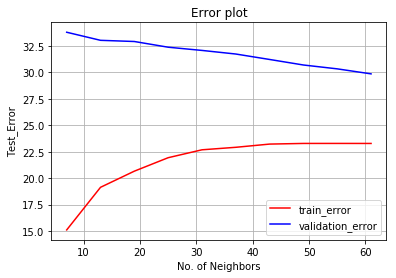

In [235]:
neig = [i for i in k_range]
error = [(1-i)*100 for i in bow_train.cv_results_['mean_train_score']]
error_test = [(1-i)*100 for i in bow_train.cv_results_['mean_test_score']]
plt.plot(neig, error,'r',label='train_error')
plt.plot(neig, error_test,'b',label='validation_error')
plt.title('Error plot')
plt.xlabel('No. of Neighbors')
plt.ylabel('Test_Error')
plt.grid('on')
plt.legend()
plt.show()

In [236]:
# ============================== KNN with k = optimal_k ===============================================


exists = os.path.isfile(knn_trained_bow)
if exists:
    print("yes exist")
    knn_optimal = load(knn_trained_bow)
    bow_pred = knn_optimal.predict(final_bow_test)
    bow_train_pred = knn_optimal.predict(final_bow_count_vect)
else:
    print("not exist")
    # instantiate learning model k = optimal_k
    knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k , algorithm = 'brute')

    # fitting the model
    knn_optimal.fit(final_bow_count_vect, y_train)

    # predict the response
    bow_pred = knn_optimal.predict(final_bow_test)
    bow_train_pred = knn_optimal.predict(final_bow_count_vect)
    dump(knn_optimal,knn_trained_bow)


yes exist



Confusion Matrix for Train data


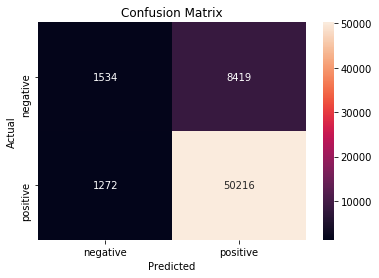


Confusion Matrix for Test data


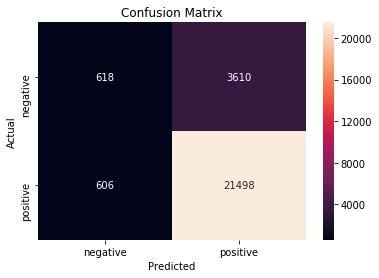

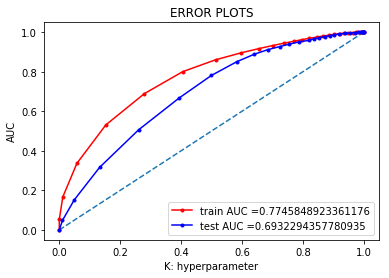


AUC (Train): 0.7745848923361176

AUC (Test): 0.6932294357780935

F1 SCORE (Train) : 0.9119984017870927

F1 SCORE (Test) : 0.910700669321359

RECALL (Train): 0.9752952144188938

RECALL (Test): 0.9725841476655809

PRECISION  (Train) : 0.8564168158949433

PRECISION  (Test) : 0.8562211247411183


In [237]:
# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,bow_train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,bow_pred)

# plot AUC
train_auc, test_auc = plotAUC_ROC(knn_optimal,final_bow_count_vect, y_train ,final_bow_test, y_test)
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)

print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,bow_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,bow_train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, bow_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, bow_train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, bow_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, bow_train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### [5.1.2] Applying KNN brute force on TFIDF, using GridSearchCV

=======Training========
0.6270425413945637
{'n_neighbors': 61}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=61, p=2,
           weights='uniform')


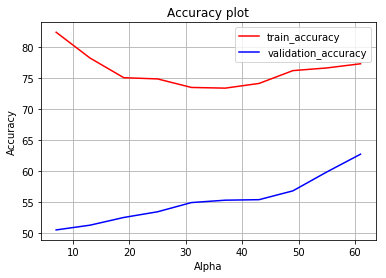

In [238]:
path_tfidf_train = '/home/pranay/Amazon Assignments/KNN/TFIDF/tfidf_brute_train'

exists = os.path.isfile(path_tfidf_train)
if exists:
    tfidf_train = load(path_tfidf_train)
else:
    print("not exist")
    tfidf_train = finding_best_k(final_tf_idf,y_train, 'brute')
    dump(tfidf_train,path_tfidf_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

plotAccuracyGraph(tfidf_train)


Confusion Matrix for Train data


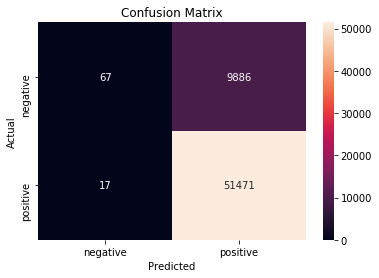


Confusion Matrix for Test data


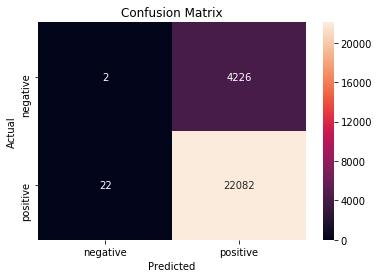

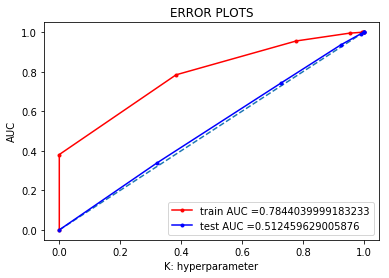


AUC (Train): 0.7844039999183233

AUC (Test): 0.512459629005876

F1 SCORE (Train) : 0.9122424564668351

F1 SCORE (Test) : 0.9122531603734612

RECALL (Train): 0.9996698259788689

RECALL (Test): 0.9990047050307637

PRECISION  (Train) : 0.8388773897028864

PRECISION  (Test) : 0.8393644518777558


In [239]:
path_tfidf_optimal = '/home/pranay/Amazon Assignments/KNN/TFIDF/tfidf_brute_optimal'

exists = os.path.isfile(path_tfidf_optimal)

if exists:
    knn_optimal = load(path_tfidf_optimal)
    # predict the response
    tfidf_pred = knn_optimal.predict(final_tfidf_test)
    tfidf_train_pred = knn_optimal.predict(final_tf_idf)
else:
    knn_optimal= train_with_optimal_k(9,'brute') # it will return trained model with best k

    # fitting the model
    knn_optimal.fit(final_tf_idf, y_train)

    # predict the response
    tfidf_pred = knn_optimal.predict(final_tfidf_test)
    tfidf_train_pred = knn_optimal.predict(final_tf_idf)
    dump(knn_optimal, path_tfidf_optimal)


# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,tfidf_train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,tfidf_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(knn_optimal,final_tf_idf, y_train,final_tfidf_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,tfidf_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,tfidf_train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, tfidf_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, tfidf_train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, tfidf_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, tfidf_train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### [5.1.3] Applying KNN brute force on AVG W2V, using GridSearchCV

=======Training========
0.8857065392653695
{'n_neighbors': 61}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=61, p=2,
           weights='uniform')


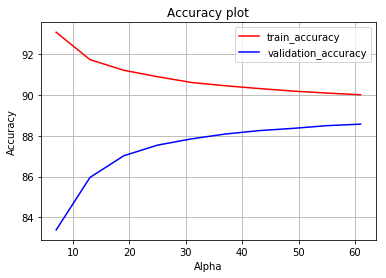

In [240]:
path_w2v_train = '/home/pranay/Amazon Assignments/KNN/W2V/w2v_brute_train'

exists = os.path.isfile(path_w2v_train)
if exists:
    w2v_train = load(path_w2v_train)

else:
    print("not exist")
    w2v_train = finding_best_k(final_w2v_train,y_train,'brute')
    dump(w2v_train,path_w2v_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_train.best_score_)
print (w2v_train.best_params_)
print (w2v_train.best_estimator_)

plotAccuracyGraph(w2v_train)

yes exist

Confusion Matrix for Train data


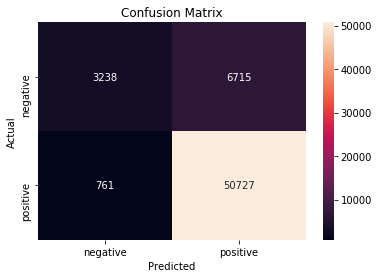


Confusion Matrix for Test data


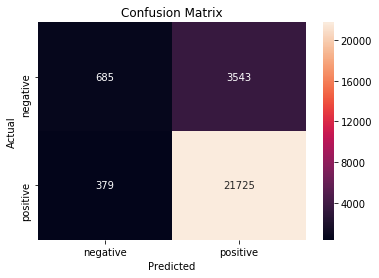

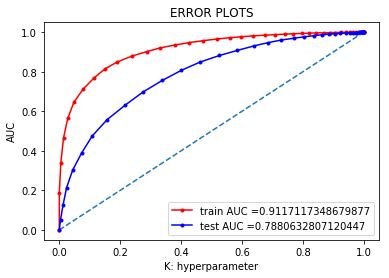


AUC (Train): 0.9117117348679877

AUC (Test): 0.7880632807120447

F1 SCORE (Train) : 0.931368768934178

F1 SCORE (Test) : 0.9172084775816939

RECALL (Train): 0.9852198570540709

RECALL (Test): 0.9828537821208831

PRECISION  (Train) : 0.8830994742522893

PRECISION  (Test) : 0.8597831249010607


In [241]:
path_w2v_optimal = '/home/pranay/Amazon Assignments/KNN/W2V/w2v_brute_optimal'

# best_k_value = w2v_train.best_params_.get('n_neighbors')

exists = os.path.isfile(path_w2v_optimal)

if exists:
    print("yes exist")
    knn_optimal = load(path_w2v_optimal)
    # predict the response
    test_pred = knn_optimal.predict(final_w2v_test)
    train_pred = knn_optimal.predict(final_w2v_train)

else:   
    print("not exist")
    knn_optimal= train_with_optimal_k(40,'brute') # it will return trained model with best k

    # fitting the model
    knn_optimal.fit(final_w2v_train, y_train)

    # predict the response
    test_pred = knn_optimal.predict(final_w2v_test)
    train_pred = knn_optimal.predict(final_w2v_train)
    dump(knn_optimal, path_w2v_optimal)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(knn_optimal,final_w2v_train, y_train,final_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### [5.1.4] Applying KNN brute force on TFIDF W2V, using GridSearchCV

yes exist
=======Training========
0.8531849168462964
{'n_neighbors': 61}
KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=61, p=2,
           weights='uniform')


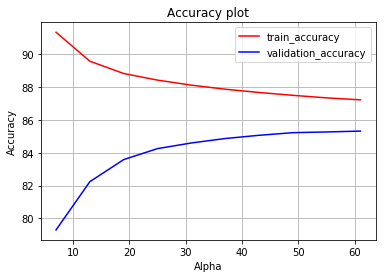

In [242]:
path_w2v_tfidf_train = '/home/pranay/Amazon Assignments/KNN/W2V TFIDF/w2v_tfidf_brute_train'

exists = os.path.isfile(path_w2v_tfidf_train)
if exists:
    print("yes exist")
    w2v_tfidf_train = load(path_w2v_tfidf_train)

else:   
    print("not exist")
    w2v_tfidf_train = finding_best_k(final_tfidf_w2v_tr,y_train,'brute')
    dump(w2v_tfidf_train,path_w2v_tfidf_train )

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_tfidf_train.best_score_)
print (w2v_tfidf_train.best_params_)
print (w2v_tfidf_train.best_estimator_)

plotAccuracyGraph(w2v_tfidf_train) 

yes exist

Confusion Matrix for Train data


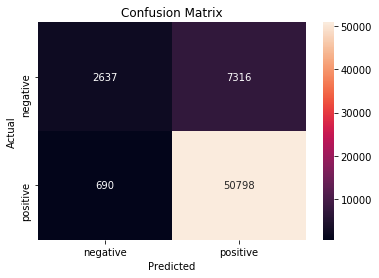


Confusion Matrix for Test data


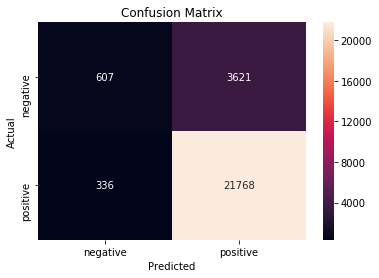

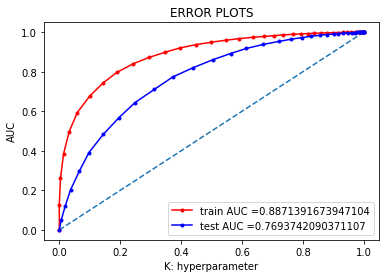


AUC (Train): 0.8871391673947104

AUC (Test): 0.7693742090371107

F1 SCORE (Train) : 0.9269538877027791

F1 SCORE (Test) : 0.9166824584675637

RECALL (Train): 0.9865988191423244

RECALL (Test): 0.9847991313789359

PRECISION  (Train) : 0.8741095088963072

PRECISION  (Test) : 0.8573791799598252


In [243]:
path_w2v_tfidf_optimal = '/home/pranay/Amazon Assignments/KNN/W2V TFIDF/w2v_tfidf_brute_optimal'

# best_k_value = w2v_tfidf_train.best_params_.get('n_neighbors')

exists = os.path.isfile(path_w2v_tfidf_optimal)
if exists:
    print("yes exist")
    knn_optimal = load(path_w2v_tfidf_optimal)
    # predict the response
    test_pred = knn_optimal.predict(final_tfidf_w2v_test)
    train_pred = knn_optimal.predict(final_tfidf_w2v_tr)

else:   
    print("not exist")
    knn_optimal= train_with_optimal_k(40,'brute') # it will return trained model with best k

    # fitting the model
    knn_optimal.fit(final_tfidf_w2v_tr, y_train)

    # predict the response
    test_pred = knn_optimal.predict(final_tfidf_w2v_test)
    train_pred = knn_optimal.predict(final_tfidf_w2v_tr)
    dump(knn_optimal,path_w2v_tfidf_optimal)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(knn_optimal,final_tfidf_w2v_tr, y_train,final_tfidf_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

## [5.2] Applying KNN kd-tree

### Note : For KD-Tree algorithm, we have trained model on '33k' points and top 5000 feautes only

In [244]:
X = final['preprocessed_reviews'][:33000]
y = final['Score'][:33000]

# split the data set into train and test
X_train, x_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,random_state=0)

print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(26400,) (6600,) (26400,) (6600,)


### [5.2.1] Applying KNN kd-tree on BOW, using GridSearchCV

In [245]:
bow_trained_count_vect2='/home/pranay/ML trained models/BoW/bow_trained_count_vect2'

#BoW

# Train Vectorizor
# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(bow_trained_model_25000)

if exists:
    print("yes exist")
    final_bow_count_vect = load(bow_trained_model_25000) 
    bow_count_vect = load(bow_trained_count_vect)
    print("the type of count vectorizer ",type(final_bow_count_vect))
    print("the shape of out text BOW vectorizer ",final_bow_count_vect.get_shape())
    print("the number of unique words ", final_bow_count_vect.get_shape()[1])
else:
    print("not exist")
    bow_count_vect = CountVectorizer(min_df=10, max_features=5000) #in scikit-learn
    bow_count_vect.fit(X_train)
    print("some feature names ", bow_count_vect.get_feature_names()[:10])
    print('='*50)
    final_bow_count_vect = bow_count_vect.fit_transform(X_train)
    print("the type of count vectorizer ",type(final_bow_count_vect))
    print("the shape of out text BOW vectorizer ",final_bow_count_vect.get_shape())
    print("the number of unique words ", final_bow_count_vect.get_shape()[1])
    dump(final_bow_count_vect, bow_trained_model_25000) 
    dump(bow_count_vect, bow_trained_count_vect2) 

    
# Test Vectorizor
exists = os.path.isfile(bow_test_model_25000)

if exists:
    final_bow_test = load(bow_test_model_25000)
else:
    final_bow_test = bow_count_vect.transform(x_test)
    dump(final_bow_test,bow_test_model_25000 )
    final_bow_test.shape

yes exist
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (26400, 5000)
the number of unique words  5000


=======Training========
0.7165645157303911
{'n_neighbors': 61}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=61, p=2,
           weights='uniform')


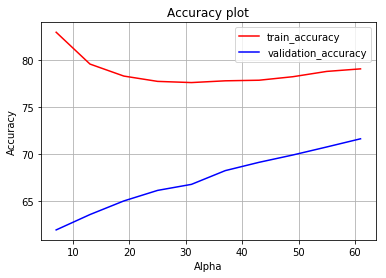

In [246]:
bow_kdtree_train = '/home/pranay/Amazon Assignments/KNN/BOW/bow_kdtree_train'

exists = os.path.isfile(bow_kdtree_train)
if exists:
    bow_train = load(bow_kdtree_train)

else:   
    print("not exist")
    bow_train = finding_best_k(final_bow_count_vect,y_train, 'kd_tree')
    dump(bow_train, bow_kdtree_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (bow_train.best_score_)
print (bow_train.best_params_)
print (bow_train.best_estimator_)

plotAccuracyGraph(bow_train) 

yes exist

Confusion Matrix for Train data


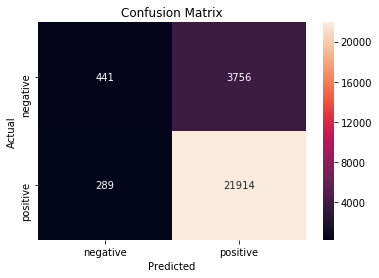


Confusion Matrix for Test data


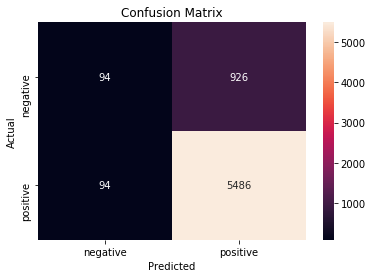

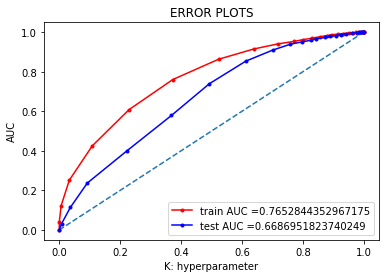


AUC (Train): 0.7652844352967175

AUC (Test): 0.6686951823740249

F1 SCORE (Train) : 0.9155056085893928

F1 SCORE (Test) : 0.9149432955303536

RECALL (Train): 0.9869837409359096

RECALL (Test): 0.9831541218637992

PRECISION  (Train) : 0.8536813400857032

PRECISION  (Test) : 0.8555832813474735


In [247]:
path_bow_kdtree_optimal = '/home/pranay/Amazon Assignments/KNN/BOW/bow_kdtree_optimal'

exists = os.path.isfile(path_bow_kdtree_optimal)
if exists:
    print("yes exist")
    knn_optimal = load(path_bow_kdtree_optimal)
    # predict the response
    bow_pred = knn_optimal.predict(final_bow_test)
    bow_train_pred = knn_optimal.predict(final_bow_count_vect)

else:   
    print("not exist")
    knn_optimal= train_with_optimal_k(best_k_value,'kd_tree') # it will return trained model with best k

    # fitting the model
    knn_optimal.fit(final_bow_count_vect,y_train)

    # predict the response
    bow_pred = knn_optimal.predict(final_bow_test)
    bow_train_pred = knn_optimal.predict(final_bow_count_vect)
    dump(knn_optimal,path_bow_kdtree_optimal)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,bow_train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,bow_pred)

# plot AUC
train_auc, test_auc = plotAUC_ROC(knn_optimal,final_bow_count_vect, y_train ,final_bow_test, y_test)
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,bow_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,bow_train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, bow_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, bow_train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, bow_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, bow_train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### [5.2.2] Applying KNN kd-tree on TFIDF, using GridSearchCV

In [248]:
# Train Vectorizor
# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(tf_idf_trained_model_25000)
if exists:
    print("yes exist")
    final_tf_idf = load(tf_idf_trained_model_25000)
    tf_idf_vect = load(tfidf_vectorizer)
    print("the type of count vectorizer ",type(final_tf_idf))
    print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
    print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
    
else:
    print("not exist")
    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=5000)
    tf_idf_vect.fit(X_train)
    print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
    print('='*50)

    final_tf_idf = tf_idf_vect.transform(X_train)
    print("the type of count vectorizer ",type(final_tf_idf))
    print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
    print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])
    dump(final_tf_idf, tf_idf_trained_model_25000) 
    dump(tf_idf_vect, tfidf_vectorizer) 


# Test Vectorizor

exists = os.path.isfile(tf_idf_test_model_25000)

if exists:
    print("yes exist")
    final_tfidf_test = load(tf_idf_test_model_25000)
else:
    print("not exist")
    final_tfidf_test = tf_idf_vect.transform(x_test)
    dump(final_tfidf_test,tf_idf_test_model_25000 )
    final_tfidf_test.shape

yes exist
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (26400, 5000)
the number of unique words including both unigrams and bigrams  5000
yes exist


=======Training========
0.757998306854127
{'n_neighbors': 61}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=61, p=2,
           weights='uniform')


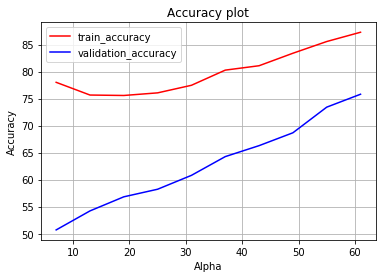

In [249]:
path_tfidf_train = '/home/pranay/Amazon Assignments/KNN/TFIDF/tfidf_kdtree_train'

exists = os.path.isfile(path_tfidf_train)
if exists:
    tfidf_train = load(path_tfidf_train)
else:
    print("not exist")
    tfidf_train = finding_best_k(final_tf_idf,y_train, 'kd_tree')
    dump(tfidf_train,path_tfidf_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (tfidf_train.best_score_)
print (tfidf_train.best_params_)
print (tfidf_train.best_estimator_)

plotAccuracyGraph(tfidf_train)

In [250]:
final_tf_idf.shape, y_train.shape,final_tfidf_test.shape,y_test.shape

((26400, 5000), (26400,), (6600, 5000), (6600,))


Confusion Matrix for Train data


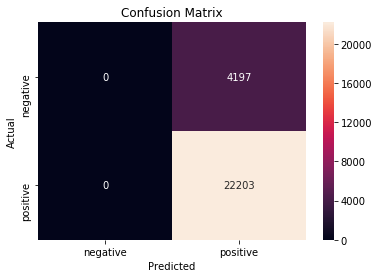


Confusion Matrix for Test data


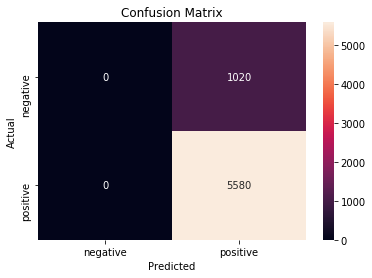

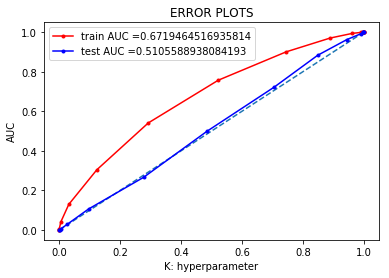


AUC (Train): 0.6719464516935814

AUC (Test): 0.5105588938084193

F1 SCORE (Train) : 0.913647305721869

F1 SCORE (Test) : 0.916256157635468

RECALL (Train): 1.0

RECALL (Test): 1.0

PRECISION  (Train) : 0.8410227272727273

PRECISION  (Test) : 0.8454545454545455


In [251]:
path_tfidf_kdtree_optimal = '/home/pranay/Amazon Assignments/KNN/TFIDF/tfidf_kdtree_optimal'

exists = os.path.isfile(path_tfidf_kdtree_optimal)

if exists:
    knn_optimal = load(path_tfidf_kdtree_optimal)

else:
    knn_optimal= train_with_optimal_k(35,'kd_tree') # it will return trained model with best k

    # fitting the model
    knn_optimal.fit(final_tf_idf, y_train)

    dump(knn_optimal, path_tfidf_kdtree_optimal)

# # instantiate learning model k = optimal_k
# knn_optimal = KNeighborsClassifier(n_neighbors=15 , algorithm = 'kd_tree')


# # fitting the model
# knn_optimal.fit(final_tf_idf, y_train)

# predict the response
tfidf_pred = knn_optimal.predict(final_tfidf_test)
tfidf_train_pred = knn_optimal.predict(final_tf_idf)

# dump(knn_optimal, path_tfidf_kdtree_optimal)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,tfidf_train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,tfidf_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(knn_optimal,final_tf_idf, y_train,final_tfidf_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,tfidf_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,tfidf_train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, tfidf_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, tfidf_train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, tfidf_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, tfidf_train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### [5.2.3] Applying KNN kd-tree on AVG W2V, using GridSearchCV

In [252]:
# Train your own Word2Vec model using your own text corpus

# Train data
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

# Test data
list_of_test_sentence = []
for sentance in x_test:
    list_of_test_sentence.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
# train data
w2v_model_tr=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
# train model on test data
w2v_model_test = Word2Vec(list_of_test_sentence,min_count=5,size=50, workers=4)


# train data operation
w2v_train_words = list(w2v_model_tr.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_train_words))
print("sample words ", w2v_train_words[0:50])

# test data operation
w2v_test_words = list(w2v_model_test.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_test_words))
print("sample words ", w2v_test_words[0:50])

# average Word2Vec

# train data operation
exists = os.path.isfile(avg_w2v_trained_model_25000)

if exists:
    print("yes exist")
    final_w2v_train = load(avg_w2v_trained_model_25000)
else:
    print("not exist")
    # compute average word2vec for each review.
    final_w2v_train = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_sentance): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words:
                vec = w2v_model_tr.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_train.append(sent_vec)
    print(len(final_w2v_train))
    print(len(final_w2v_train[0]))
    dump(final_w2v_train,avg_w2v_trained_model_25000)


# test data operation
exists = os.path.isfile(avg_w2v_test_model_25000)

if exists:
    print("yes exist")
    final_w2v_test = load(avg_w2v_test_model_25000)
else:
    print("not exist")
    final_w2v_test = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in tqdm(list_of_test_sentence): # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words:
                vec = w2v_model_test.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        final_w2v_test.append(sent_vec)
    print(len(final_w2v_test))
    print(len(final_w2v_test[0]))
    dump(final_w2v_test,avg_w2v_test_model_25000)

number of words that occured minimum 5 times  9823
sample words  ['cereal', 'rice', 'awesome', 'daughter', 'loves', 'good', 'buy', 'target', 'way', 'cheaper', 'drinking', 'kona', 'many', 'years', 'paying', 'oz', 'tullys', 'blend', 'coffee', 'best', 'drinker', 'order', 'via', 'subscribe', 'save', 'always', 'new', 'case', 'actual', 'ship', 'date', 'not', 'keep', 'house', 'seems', 'like', 'boxes', 'turn', 'around', 'last', 'one', 'kids', 'love', 'hits', 'sweet', 'tooth', 'right', 'step', 'away', 'healthiest']
number of words that occured minimum 5 times  4834
sample words  ['haribo', 'makes', 'wide', 'range', 'candies', 'including', 'world', 'class', 'goodies', 'not', 'one', 'frogs', 'made', 'hard', 'gummi', 'green', 'except', 'thin', 'white', 'layer', 'bellies', 'might', 'unless', 'told', 'no', 'taste', 'texture', 'difference', 'substances', 'case', 'flavor', 'good', 'definitely', 'lime', 'advertised', 'maybe', 'somebody', 'likes', 'stuff', 'set', 'bag', 'office', 'first', 'sample', 'lik

=======Training========
0.8602306953513348
{'n_neighbors': 61}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=61, p=2,
           weights='uniform')


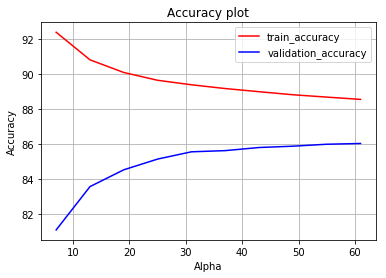

In [253]:
path_w2v_kdtree_train = '/home/pranay/Amazon Assignments/KNN/W2V/w2v_kdtree_train'

exists = os.path.isfile(path_w2v_kdtree_train)
if exists:
    w2v_train = load(path_w2v_kdtree_train)

else:
    print("not exist")
    w2v_train = finding_best_k(final_w2v_train,y_train, 'kd_tree')
    dump(w2v_train,path_w2v_kdtree_train)

# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_train.best_score_)
print (w2v_train.best_params_)
print (w2v_train.best_estimator_)

plotAccuracyGraph(w2v_train)

not exist

Confusion Matrix for Train data


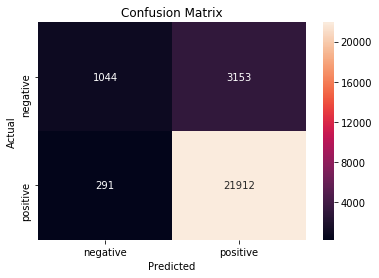


Confusion Matrix for Test data


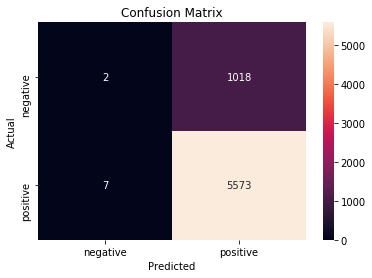

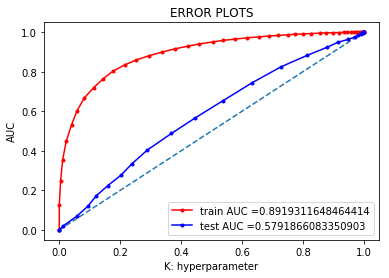


AUC (Train): 0.8919311648464414

AUC (Test): 0.5791866083350903

F1 SCORE (Train) : 0.9271388677329272

F1 SCORE (Test) : 0.9157834196039766

RECALL (Train): 0.986893663018511

RECALL (Test): 0.9987455197132616

PRECISION  (Train) : 0.8742070616397367

PRECISION  (Test) : 0.8455469579729935


In [254]:
path_w2v_kdtree_optimal = '/home/pranay/Amazon Assignments/KNN/W2V/w2v_kdtree_optimal'

exists = os.path.isfile(path_w2v_kdtree_optimal)
if exists:
    print("yes exist")
    knn_optimal = load(path_w2v_kdtree_optimal)

else:   
    print("not exist")

    knn_optimal= train_with_optimal_k(45,'kd_tree') # it will return trained model with best k

    # fitting the model
    knn_optimal.fit(final_w2v_train, y_train)

# knn_optimal = KNeighborsClassifier(n_neighbors=30 , algorithm = 'kd_tree')

# # fitting the model
# knn_optimal.fit(final_w2v_train, y_train)

# predict the response
test_pred = knn_optimal.predict(final_w2v_test)
train_pred = knn_optimal.predict(final_w2v_train)
# dump(knn_optimal, path_w2v_kdtree_optimal)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(knn_optimal,final_w2v_train, y_train,final_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

### [5.2.4] Applying KNN kd-tree on TFIDF W2V, using GridSearchCV

In [255]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

# TF-IDF weighted Word2Vec

# Train data operation
# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_trained_model_25000)

if exists:
    print("yes exist")
    final_tfidf_w2v_tr = load(w2v_tf_idf_trained_model_25000)
else:   
    print("not exist")
    tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    final_tfidf_w2v_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_train_words and word in tfidf_feat:
                vec = w2v_model_tr.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_tr.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_tr,w2v_tf_idf_trained_model_25000)
    

# Test data operation ============

# store model to hard disk if exist then load model directly from memory
exists = os.path.isfile(w2v_tf_idf_test_model_25000)

if exists:
    print("yes exist")
    final_tfidf_w2v_test = load(w2v_tf_idf_test_model_25000) 

else:   
    print("not exist")
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
    final_tfidf_w2v_test = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_test_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_test_words and word in tfidf_feat:
                vec = w2v_model_test.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        final_tfidf_w2v_test.append(sent_vec)
        row += 1
    dump(final_tfidf_w2v_test,w2v_tf_idf_test_model_25000)
        

yes exist
yes exist


yes exist
=======Training========
0.8276248326019916
{'n_neighbors': 61}
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=61, p=2,
           weights='uniform')


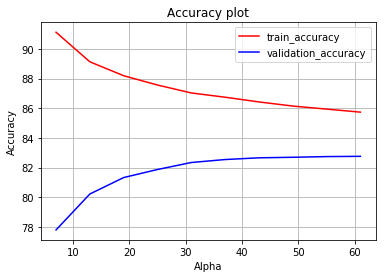

In [256]:
path_w2v_tfidf_kdtree_train = '/home/pranay/Amazon Assignments/KNN/W2V TFIDF/w2v_tfidf_kdree_train'

exists = os.path.isfile(path_w2v_tfidf_kdtree_train)
if exists:
    print("yes exist")
    w2v_tfidf_train = load(path_w2v_tfidf_kdtree_train)
else:   
    print("not exist")
    w2v_tfidf_train = finding_best_k(final_tfidf_w2v_tr,y_train, 'kd_tree')
    dump(w2v_tfidf_train,path_w2v_tfidf_kdtree_train )
    
# view the complete results (list of named tuples)
print("=======Training========")
print (w2v_tfidf_train.best_score_)
print (w2v_tfidf_train.best_params_)
print (w2v_tfidf_train.best_estimator_)

plotAccuracyGraph(w2v_tfidf_train) 

yes exist

Confusion Matrix for Train data


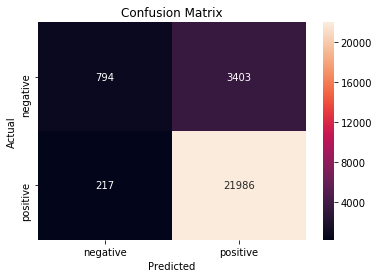


Confusion Matrix for Test data


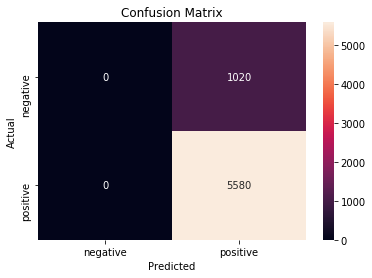

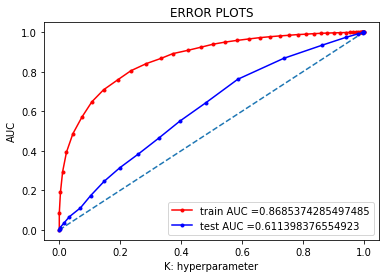


AUC (Train): 0.8685374285497485

AUC (Test): 0.611398376554923

F1 SCORE (Train) : 0.9239367961001849

F1 SCORE (Test) : 0.916256157635468

RECALL (Train): 0.9902265459622573

RECALL (Test): 1.0

PRECISION  (Train) : 0.865965575642995

PRECISION  (Test) : 0.8454545454545455


In [257]:
path_w2v_tfidf_kdtree_optimal = '/home/pranay/Amazon Assignments/KNN/W2V TFIDF/w2v_tfidf_kdtree_optimal'

exists = os.path.isfile(path_w2v_tfidf_kdtree_optimal)
if exists:
    print("yes exist")
    knn_optimal = load(path_w2v_tfidf_kdtree_optimal)

else:   
    print("not exist")

    knn_optimal= train_with_optimal_k(43,'kd_tree') # it will return trained model with best k

    # fitting the model
    knn_optimal.fit(final_tfidf_w2v_tr, y_train)

    # predict the response
    dump(knn_optimal,path_w2v_tfidf_kdtree_optimal)


# knn_optimal = KNeighborsClassifier(n_neighbors=49 , algorithm = 'kd_tree')

# # fitting the model
# knn_optimal.fit(final_tfidf_w2v_tr, y_train)

# predict the response
test_pred = knn_optimal.predict(final_tfidf_w2v_test)
train_pred = knn_optimal.predict(final_tfidf_w2v_tr)

# dump(knn_optimal,path_w2v_tfidf_kdtree_optimal)

# plot confusion matrix

print('\n'+color.BOLD +'Confusion Matrix for Train data'+color.END)
plotConfusionMatrix(y_train,train_pred)

print('\n'+color.BOLD +'Confusion Matrix for Test data'+color.END)
plotConfusionMatrix(y_test,test_pred)

# plot AUC
train_auc,test_auc = plotAUC_ROC(knn_optimal,final_tfidf_w2v_tr, y_train,final_tfidf_w2v_test, y_test )
print('\n'+color.RED+'AUC (Train): '+color.END+color.BOLD+str(train_auc)+color.END)
print('\n'+color.RED+'AUC (Test): '+color.END+color.BOLD+str(test_auc)+color.END)

# f1 score
score = f1_score(y_test,test_pred)
print('\n'+color.RED+'F1 SCORE (Train) : '+color.END+color.BOLD+str(f1_score(y_train,train_pred))+color.END)
print('\n'+color.RED+'F1 SCORE (Test) : '+color.END+color.BOLD+str(score)+color.END)

# recall
recall = metrics.recall_score(y_test, test_pred)
print('\n'+color.RED+'RECALL (Train): '+color.END+color.BOLD+str(metrics.recall_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'RECALL (Test): '+color.END+color.BOLD+str(recall)+color.END)

# precision
precision = metrics.precision_score(y_test, test_pred)
print('\n'+color.RED+'PRECISION  (Train) : '+color.END+color.BOLD+str(metrics.precision_score(y_train, train_pred))+color.END)
print('\n'+color.RED+'PRECISION  (Test) : '+color.END+color.BOLD+str(precision)+color.END)

# [6] Conclusions

In [260]:
import pandas as pd
print(color.BOLD+'KNN Brute Force, trained on 100k Points')
dataframe = pd.DataFrame(
{
    "Model": ['BOW','TF-IDF','Avg W2V','AVG W2V-TFIDF'],
    "K value": [30,30,35,37],
    "AUC": [0.6932,0.5124,0.7830,0.7693],
    "F1- Score ": [0.9104,0.9122,0.9172,0.9166],
    "Recall ": [0.9725,0.999,0.98285,0.98647],
    "Precision ": [0.8562,0.8393,0.85978,0.8573],
}

)
dataframe

KNN Brute Force, trained on 100k Points


,Model,K value,AUC,F1- Score,Recall,Precision
0,BOW,30,0.6932,0.9104,0.97250,0.85620
1,TF-IDF,30,0.5124,0.9122,0.99900,0.83930
2,Avg W2V,35,0.7830,0.9172,0.98285,0.85978
3,AVG W2V-TFIDF,37,0.7693,0.9166,0.98647,0.85730


In [261]:
print(color.BOLD+'KNN KD-Tree, trained on 33k Points')
dataframe = pd.DataFrame(
{
    "Model": ['BOW','TF-IDF','Avg W2V','AVG W2V-TFIDF'],
    "K value": [30,35,45,43],
    "AUC": [0.6686,0.5105,0.5791,0.6113],
    "F1- Score ": [0.9149,0.9162,0.9157,0.91625],
    "Recall ": [0.9831,1.0,0.9987,1.0],
    "Precision ": [0.8558,0.84545,0.8455,0.84548],
}
)
dataframe

KNN KD-Tree, trained on 33k Points


,Model,K value,AUC,F1- Score,Recall,Precision
0,BOW,30,0.6686,0.91490,0.9831,0.85580
1,TF-IDF,35,0.5105,0.91620,1.0000,0.84545
2,Avg W2V,45,0.5791,0.91570,0.9987,0.84550
3,AVG W2V-TFIDF,43,0.6113,0.91625,1.0000,0.84548
